In [1]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 
import pingouin as pg

#stats
from statsmodels.stats.anova import AnovaRM
#import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
#import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel
import scipy.io

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture

import matplotlib.ticker as ticker


#import math, pywt

In [2]:
# functions# functions
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_abs_speed_sacc(vec):#this is same as find_abs_speed, but now using a smoothed speed array,for saccade 
    # because we're using.iloc and .values, need to make sure the 
    # vec input is from dataframe
    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)

#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr,dtype = object)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen),np.ones(len(cx) - 3*winlen),np.zeros(2*winlen)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen,i[0]]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen : i[0] + 2*winlen]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen : i[0] + 2*winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift
#this is originally used to linearly interpolate 
#missing saccade data
#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10,**kwargs): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    if kwargs:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)), **kwargs),axis = 1,raw = True) 
    else:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True) 

        

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 

        normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
        norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        
        normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
        norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    xBL = np.linspace(0,blt,norm_sterrBL.shape[1])
    if blHeight == None:
        blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]

    #plot mean plot for the baseline and for the trial
    [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                        color = cList[i],alpha = 0.2,)  for i in range(condN)]
    [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],linewidth = 2.5,color = cList[i],) for i in range(condN) ]

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],color = cList[i],linewidth = 2,) for i in range(condN) ]
    [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,norm_lower.min().min(),
                         norm_upper.max().max(),linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,norm_upper.max().max(),m,c = 'black',size = textSize)
    
    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
        
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd
# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt
def findGazeShift2d(xvec,yvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 0.2,
                   baselinePadding = 0,shiftWhere = False,):
    """
    @ xvec =  the gaze position horizontal channel
    @ yvec = the gaze position vertical channel
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if ***none***, calculate relative baseline  (i.e. in regard to position before and after shift)
                if ***list***, it indicate baseline rage, e.g. [500,1000]
                if ***numeric***, use the numeric value as baseline
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 0.2% 
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    @ shiftWhere = if True, only return the index where shift occurs. This is useful if use needs to combine
                    the horizontal and vertical gaze arrays. 
                    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_pup(xvec).astype(float)
    dy = find_abs_speed_pup(yvec).astype(float)
    dxySqrt = eDist(dx,dy)

    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = np.nanmedian(dxySqrt) + medianVariance(dxySqrt) *threshold
    cx = dxySqrt>thresholdx
    
    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)
    
    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))   

    # if user only needs to know the location where shift occured, return a boolean array
    # where 1 =  shift occur, 0 = no shift
    if shiftWhere:
        try:
            fillLoc = np.array([i[0] for i in msCluster]) 
            gazeshift[fillLoc] = 1
        except IndexError:
            pass
        return gazeshift

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            
            #calculate gaze position before the shift occured 
            if type(baseline) != int:
                try:
                    posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                    posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
            else: #if user decide to use a numerical value as the baseline, use that
                posbef = baseline

            #calculate the gaze position afte the shift
            try:
                posaft = np.nanmean(xvec.iloc[i[-1] : i[-1] + winlen]) 
            except:    
                posaft = np.nanmean(xvec[i[-1]: i[-1] + winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

def eDist(a,b): #eucleadian distance
    return np.sqrt(a**2+b**2)

In [3]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            minAllowedPup = 2000
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < minAllowedPup)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        temp = np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt, borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft))
        
        rejarr_padded[temp.astype(int)] = 1
    except ValueError:
        rejarr_padded = rejarr
       
    
    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        #rejarr_blkMask = np.r_[rejarr_blkMask,np.concatenate(consecutiveBlkFilter)]
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError:
        # if the user want to only return the blink mask, and that no outliter is found
        # return an empty mask, else, return pupil size.
        if returnMask:
            return np.zeros(len(rejarr))
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq],dtype = object)

    #find four index for interpolation
    indexForInterp = np.asarray([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster],dtype = object).astype(int)
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timesta|mp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup

In [25]:
def cohenD(group1,group2):
    # Calculate means
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    # Calculate standard deviations
    std1 = np.std(group1, ddof=1)  # Sample standard deviation
    std2 = np.std(group2, ddof=1)

    # Calculate sample sizes
    n1 = len(group1)
    n2 = len(group2)

    # Calculate pooled standard deviation
    pooledstd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Calculate Cohen's d
    cohend = (mean1 - mean2) / pooledstd
    return cohend

# rsa

In [4]:
loadRaw = False
mergeTags = False
loadScanpath = True
correctOnly = False
trlType = ['precue','retrocue']
comparison = 'stim2delay'#'stim2delay'#'delay2delay' #default should be 'stim2delay'


In [5]:
"""load trial ordering"""
precuePath1 = glob.glob("Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlOrdering/311to352/*.csv")
retrocuePath1 = glob.glob("Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlOrdering/360to400/*.csv")

#load trial info
if len(trlType) != 0:
    thisPath = precuePath1 + retrocuePath1
elif trlType == 'precue':
    thisPath = precuePath1
else:
    thisPath = retrocuePath1

#load trl ordering    
trlOrdering = pd.DataFrame()
for i in thisPath:
    trlOrdering = pd.concat([trlOrdering,pd.read_csv(i).iloc[:,2:]]) 

trlOrdering = trlOrdering.reset_index(drop=True)

In [6]:
def loadScanPathRawMat_oneSubj(subjID,comparison):
    mat_data = scipy.io.loadmat(glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/scanMatch_similarity/311to352{comparison}/*{str(int(subjID))[:3]}*.mat')[0])
    similarityArr = mat_data['similarityArr']
    
    similarityArr = np.where(similarityArr == 9999,np.nan,similarityArr)
    similarityArr = (similarityArr - np.nanmean(similarityArr, ))/np.nanstd(similarityArr)
    return similarityArr

In [7]:
def loadRSA(loadScanpath,comparison,trlOrdering,normalizationMethod = 'zscore',debug = False):
    """
    NOTE: 
    if loadScanpath == True, load scanpath, else load mutual information
    if comparison == 'stim2delay', load stim2delay. Other options are 'stim2stim','delay2delay'
    if normalizationMethod != 'zscore', will use raw similarity score. I may change this TODO in the future 
    if debug == True, will print out the shape of the trl_withScore_formatted_sp, and similarityScores after each subject iteration

    """

    """load scan path similarity"""
    if loadScanpath == True:

        trl_withScore_formatted_sp = pd.DataFrame()

        """loop through the scanpath similarity matrix for all subject, extracting relevant information"""
        for subjID in trlOrdering.participant.unique():

            #initialize empty arrays
            withinTrl = []
            acrossTrl_sameImage = []
            acrossTrl_sameImage_vis = []
            acrossTrl_sameImage_ver = []
            acrossTrl_diffImage = []
            acrossTrl_diffImage_vis = []
            acrossTrl_diffImage_ver = []

            if (subjID <= 352) : #precue
                thisFile = glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/scanMatch_similarity/311to352{comparison}/*{str(int(subjID))[:3]}*.mat')
                thisFileID = glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlID/311to352/*{str(int(subjID))[:3]}*.npy')
            else: #retrocue
                thisFile = glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/scanMatch_similarity/360to400{comparison}/*{str(int(subjID))[:3]}*.mat')
                thisFileID = glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlID/360to400/*{str(int(subjID))[:3]}*.npy')

            print('scanpath',subjID)

            #get the similarity array for this subj
            mat_data = scipy.io.loadmat(thisFile[0])
            similarityArr = mat_data['similarityArr']
            
            #for any invalid entires (i.e. 9999), cast it to nan
            similarityArr = np.where(similarityArr == 9999,np.nan,similarityArr)
            
            if normalizationMethod == 'zscore': #normalization to remove across subject variance
                similarityArr = (similarityArr - np.nanmean(similarityArr, ))/np.nanstd(similarityArr)

            #get the subj ID info, this will be used to check if the trl index are correct
            saccTrlIDs = np.load(thisFileID[0],allow_pickle = True)
            saccTrlIDs = [str((i.split('_')[0][1:],int(i.split('_')[1]),int(i.split('_')[2]))) for i in saccTrlIDs]

            #get the trial info for this subject
            trlInfo_thisSubj = trlOrdering[trlOrdering.participant == subjID].reset_index(drop = True)


            #check if the trial is is correct
            if sum(trlInfo_thisSubj.TRIALID != saccTrlIDs) == 0:

                #for each trial
                for n,i in enumerate(trlInfo_thisSubj.TRIALID.unique()):
                
                    #get the indices of other trials with the same image
                    trlThis = trlInfo_thisSubj[trlInfo_thisSubj.TRIALID == i] 
                    sameImageTrls = trlInfo_thisSubj[(trlInfo_thisSubj.stimImage == trlThis.stimImage.values[0]) &
                                                    (trlInfo_thisSubj.TRIALID != i)]
                    sameImageIndices = sameImageTrls.index.values

                    #compare current trial, to trials with the same image (the comparison trial is seperated into visual and verbal)
                    sameImageTrls_vis = trlInfo_thisSubj[(trlInfo_thisSubj.stimImage == trlThis.stimImage.values[0]) &
                                                    (trlInfo_thisSubj.TRIALID != i) & (trlInfo_thisSubj.trlType == 'visual')]
                    sameImageIndices_vis = sameImageTrls_vis.index.values

                    sameImageTrls_ver = trlInfo_thisSubj[(trlInfo_thisSubj.stimImage == trlThis.stimImage.values[0]) &
                                                    (trlInfo_thisSubj.TRIALID != i) & (trlInfo_thisSubj.trlType == 'verbal')]
                    sameImageIndices_ver = sameImageTrls_ver.index.values

                    
                    #get the indices from other trls
                    diffImageTrls = trlInfo_thisSubj[(trlInfo_thisSubj.stimImage != trlThis.stimImage.values[0])]
                    diffImageIndices = diffImageTrls.index.values  
                    diffImageTrls_vis =  trlInfo_thisSubj[(trlInfo_thisSubj.stimImage != trlThis.stimImage.values[0]) & 
                                                          (trlInfo_thisSubj.trlType == 'visual')]      
                    diffImageIndices_vis = diffImageTrls_vis.index.values

                    diffImageTrls_ver =  trlInfo_thisSubj[(trlInfo_thisSubj.stimImage != trlThis.stimImage.values[0]) & 
                                                          (trlInfo_thisSubj.trlType == 'verbal')]      
                    diffImageIndices_ver = diffImageTrls_ver.index.values



                    #extract the similarity values using the index
                    withinTrl.append(similarityArr[n,n])
                    acrossTrl_sameImage.append(np.nanmean(similarityArr[n,sameImageIndices]))
                    acrossTrl_sameImage_vis.append(np.nanmean(similarityArr[n,sameImageIndices_vis]))
                    acrossTrl_sameImage_ver.append(np.nanmean(similarityArr[n,sameImageIndices_ver]))
                    acrossTrl_diffImage.append(np.nanmean(similarityArr[n,diffImageIndices]))
                    acrossTrl_diffImage_vis.append(np.nanmean(similarityArr[n,diffImageIndices_vis]))
                    acrossTrl_diffImage_ver.append(np.nanmean(similarityArr[n,diffImageIndices_ver]))


                    
            else:
                raise('the subject trial id from trlInfo_thisSubj does not match saccTrlId')
            
            similarityScores = pd.DataFrame(dict(zip(['within','across, same image','across, diff image',
                                                    'across, same image, visTarget','across, same image, verTarget',
                                                    'across, diff image, visTarget','across, diff image, verTarget',],
                                                    [withinTrl,acrossTrl_sameImage,acrossTrl_diffImage,
                                                    acrossTrl_sameImage_vis, acrossTrl_sameImage_ver,
                                                    acrossTrl_diffImage_vis, acrossTrl_diffImage_ver])))
            if debug:
                print(f'/tab trl_withScore_formatted_sp shape is {trl_withScore_formatted_sp.shape}',
                    f'similarityScores shape is {similarityScores.shape}',
                    f'unique columns are {similarityScores.columns}')
            
            #append the subject to the larger df
            trl_withScore_formatted_sp = pd.concat([trl_withScore_formatted_sp,similarityScores],axis = 0)

        #necessary formatting
        trl_withScore = pd.concat([trlOrdering,trl_withScore_formatted_sp.reset_index(drop = True)],axis = 1)
        trl_withScore['trlOrder'] = [ast.literal_eval(i)[2] * 20 + ast.literal_eval(i)[1] for i in trl_withScore.TRIALID]
        trl_withScore['imageRepeate'] = trl_withScore.sort_values('trlOrder',ascending=True).groupby(['participant','stimImage',]).cumcount()
        trl_withScore['imageRepeate_trlType'] = trl_withScore.sort_values('trlOrder',ascending=True).groupby(['participant','stimImage','trlType']).cumcount()
        
        #make it from wide to long
        trl_withScore_formatted_sp = pd.melt(trl_withScore,  
                                             id_vars=['trlType','participant','TRIALID','stimImage','imageRepeate','imageRepeate_trlType'],
                                                        value_vars=['within', 'across, same image', 'across, diff image',
                                                                    'across, same image, visTarget','across, same image, verTarget',
                                                                    'across, diff image, visTarget','across, diff image, verTarget'],
                                                        var_name='category', value_name=f'similarityScore_{comparison}')
        
        return trl_withScore_formatted_sp
   

In [8]:
#create a plotting function that plots the difference score, for both cue tasks
#that shows visvis - visver and verver - vervis for each trial (base on whether the current trial is vis or ver)
#then take average, generate plot and calculate statistics
def plotConditionalDiff_Score(ax,comparison = 'stim2delay',score = 'similarityScore',meanType = 'subj'):
    
    #transform the trl_withScore_formatted
    loadWhat = f'{score}_{comparison}' 
    acrossTrlTemp = trl_withScore_formatted[trl_withScore_formatted.category !='within']
    acrossTrlDiff = acrossTrlTemp.pivot(index = 'TRIALID',columns = 'category', values=loadWhat).reset_index()

    #calculate the diff score
    #the diffScore_byTargetTrl is for every trial, vis - ver
    #the diffScore_byTargetTrl_signCorrected is, for every trial, use the congruent score (vis-vis, ver-ver) minus the other one
    acrossTrlDiff = acrossTrlDiff.merge(acrossTrlTemp[['TRIALID','participant','trlType','task','imageRepeate','stimImage']].drop_duplicates(),how = 'left')
    acrossTrlDiff['diffScore_byTargetTrl'] = acrossTrlDiff['across, same image, visTarget'] - acrossTrlDiff['across, same image, verTarget']
    acrossTrlDiff['diffScore_byTargetTrl_signCorrected'] = [visScore - verScore if acrossTrlDiff.trlType[n] == 'visual' else verScore - visScore for n,(verScore,visScore) in enumerate(zip(acrossTrlDiff['across, same image, verTarget'],
                                                                                acrossTrlDiff['across, same image, visTarget']))]
    
    #take mean
    if meanType == 'subj':
        print('calculating subject mean')
        acrossTrlDiffMean = acrossTrlDiff.groupby(['task','participant','trlType',]).mean(numeric_only=True).reset_index()
    else:
        acrossTrlDiffMean = acrossTrlDiff
    

    #fig,ax = plt.subplots(ncols = len(categoryOrder4Plotting), figsize = (20,10),sharex=True,sharey=True)

    
    f = sns.barplot(x = 'task',hue = 'trlType', order = ['precue','retrocue'],hue_order = ['visual','verbal'],
                palette=['green','purple',], y = 'diffScore_byTargetTrl_signCorrected',data = acrossTrlDiffMean,alpha = 0.5,ax = ax)


    
    
    ax.set_xlabel('condition',fontsize = 15)
    ax.set_title(f'mean {score} score \n congruent comparison - incongruent, {comparison}',y = 1,fontsize = 10)
   
    return acrossTrlDiffMean


In [9]:
if loadRaw:
    comArr = ['stim2stim','delay2delay','stim2delay']

    trl_withScore_formatted = pd.DataFrame()

    for thisComp in comArr:
        thisDf = loadRSA(loadScanpath = True,comparison=thisComp,trlOrdering=trlOrdering)
        if trl_withScore_formatted.shape[0] != 0:
            trl_withScore_formatted = trl_withScore_formatted.merge(thisDf,how = 'left')
        else:
            trl_withScore_formatted = thisDf

    if mergeTags:
        #load in psychopy file
        psyFull = pd.DataFrame()
        for i in glob.glob('Z:/yueying/gazeObject_YueyingDong/results/data/psychopy/*csv'):
            psyFull = pd.concat([psyFull,pd.read_csv(i)],axis = 0)
        psyFull = psyFull.reset_index(drop=True).drop_duplicates()


        #select the relevant cols, add some necessary tags
        trlInfo = psyFull[['trlType', 'corrAns','TRIALID','rspThisTrl', 'rtThisTrl']]
        trlInfo['participant'] = [ast.literal_eval(i)[0] for i in psyFull.TRIALID]
        trlInfo['corrAns_text'] = np.where(psyFull.corrAns == 0,'same','diff')
        trlInfo['rspErr'] = trlInfo.rspThisTrl == trlInfo.corrAns_text
        trlInfo['rspMade'] = (trlInfo.rspThisTrl.isnull() == False)

        #zscore rt
        rtZ = pd.DataFrame()

        for i in trlInfo.participant.unique():
            #take z value in regard to subj
            flattenedSubj = trlInfo[(trlInfo.participant == i)].rtThisTrl.values
            thisSubj_z = stats.zscore(flattenedSubj,nan_policy = 'omit')
            
            #replace the value with zscored value
            rtZ = pd.concat([rtZ,pd.DataFrame(thisSubj_z)],axis = 0)

        trlInfo['rtZ'] = rtZ.values

        #agg the other metrics
        ipaDf = pd.read_csv("Z:/yueying/gazeObject_YueyingDong/results/ipa/ipaDf.csv").iloc[:,1:]
        vviq = pd.read_csv("Z:/yueying/gazeObject_YueyingDong/results/data/vviq/vviq_311to400.csv")

        #ipa
        aggMetricDf = trl_withScore_formatted.merge(ipaDf)
        #vviq
        aggMetricDf = aggMetricDf.merge(vviq,left_on='participant',right_on='subj',how = 'left').drop('subj',axis = 1)
        #behavioral metrics
        aggMetricDf = aggMetricDf.merge(trlInfo.drop('participant',axis = 1))

    if os.path.exists('Z:/yueying/gazeObject_YueyingDong/results/similarityMetricsAgg/trl2trl_withBehav.csv'):
        print('file exists')
    else:
        aggMetricDf.to_csv('Z:/yueying/gazeObject_YueyingDong/results/similarityMetricsAgg/trl2trl_withBehav.csv')
else:
        trl_withScore_formatted = pd.read_csv('Z:/yueying/gazeObject_YueyingDong/results/similarityMetricsAgg/trl2trl_withBehav_withDiffImageByCondition.csv').iloc[:,1:]
        #trl2trl_withBehav

In [10]:
correctOnly = False

In [11]:
if correctOnly:
    trl_withScore_formatted = trl_withScore_formatted[trl_withScore_formatted.rspErr == True].reset_index(drop=True)

In [12]:
comparison ='stim2delay'
excludedCategory = ''
categoryOrder4Plotting = ['across, same image, visTarget', 'across, same image, verTarget', ]#'across, diff image',


if comparison!= 'stim2stim':
    excludedCategory = 'within'


In [13]:
meanDf = trl_withScore_formatted.groupby(['participant','category','task','trlType']).mean(numeric_only=True).reset_index()

In [14]:
trl_withScore_formatted.columns

Index(['trlType', 'participant', 'TRIALID', 'stimImage', 'imageRepeate',
       'imageRepeate_trlType', 'category', 'similarityScore_stim2stim',
       'similarityScore_delay2delay', 'similarityScore_stim2delay', 'task',
       'ipaStim', 'ipaDelay', 'score', 'corrAns', 'rspThisTrl', 'rtThisTrl',
       'corrAns_text', 'rspErr', 'rspMade', 'rtZ'],
      dtype='object')

# example scanpath matrix

In [46]:
#initialize empty arrays
withinTrl = []
acrossTrl_sameImage = []
acrossTrl_sameImage_vis = []
acrossTrl_sameImage_ver = []
acrossTrl_diffImage = []

In [48]:
# visual and semantic both
allImagesLabelArr = np.repeat(trlOrdering.stimImage.unique(),8)
allImgs = trlOrdering.stimImage.unique()
allMat = np.zeros(shape = (41,320,320))

for i,subjID in enumerate(trlOrdering.participant.unique()[:41]):

    #load data
    thisFileID = glob.glob(f'Z:/yueying/gazeObject_YueyingDong/results/variables/scanMatchTrlID/311to352/*{str(int(subjID))[:3]}*.npy')
    saccTrlIDs = np.load(thisFileID[0],allow_pickle = True)
    saccTrlIDs = [str((i.split('_')[0][1:],int(i.split('_')[1]),int(i.split('_')[2]))) for i in saccTrlIDs]
    trlInfo_thisSubj = trlOrdering[trlOrdering['TRIALID'].isin((saccTrlIDs))].reset_index(drop = True)
    similarityArr = loadScanPathRawMat_oneSubj(subjID,'stim2delay')
    
    #for holding the order
    newIndex = np.zeros(320)
    newIndex[:] = len(similarityArr)

    for thisImage,index in zip(allImgs,np.arange(0,321,8)):
        visTrlIndex = trlInfo_thisSubj[(trlInfo_thisSubj.stimImage == thisImage) & (trlInfo_thisSubj.trlType == 'visual')].index.values
        verTrlIndex =  trlInfo_thisSubj[(trlInfo_thisSubj.stimImage == thisImage) & (trlInfo_thisSubj.trlType == 'verbal')].index.values

        newIndex[index:index+len(visTrlIndex)] = visTrlIndex
        newIndex[(index+4):(index+4+len(verTrlIndex))] = verTrlIndex

    #reorder
    similarityArr_padded = np.pad(similarityArr, ((0,1),(0,1)), mode='constant', constant_values=np.nan)

    newArr = np.array([similarityArr_padded[i][newIndex.astype(int)] for i in range(len(similarityArr_padded))])
    newArr = newArr[newIndex.astype(int)] 
    
    allMat[i] = newArr

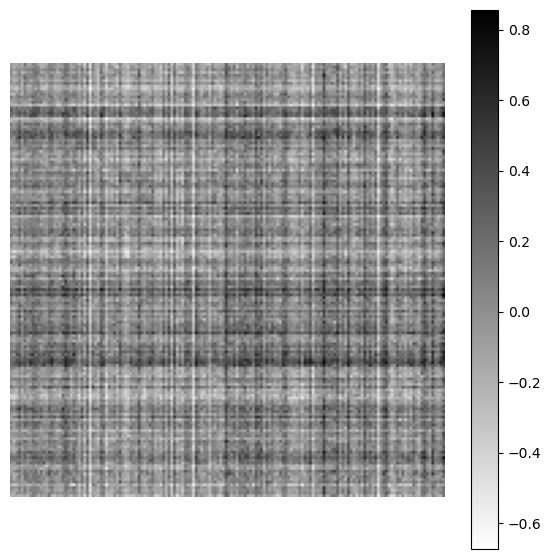

In [87]:
indStart = 0
indEnds = 320

fs(7,7)
z = np.nanmean(allMat,axis = 0)
im = plt.imshow(z[indStart:indEnds,indStart:indEnds],cmap = 'gist_yarg')
plt.axis('off')
plt.colorbar(im)

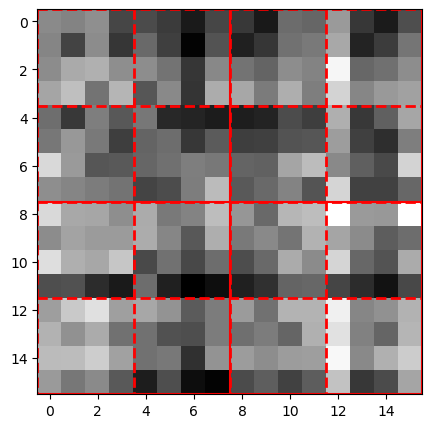

In [51]:
indStart = 16
indEnds = 32

z = np.nanmean(allMat,axis = 0)
plt.imshow(z[indStart:indEnds,indStart:indEnds],cmap = 'grey',)

plt.vlines(np.arange(0,indEnds - indStart+1,8)-0.5,-0.5, indEnds - indStart-0.5,
            colors='red',)
plt.vlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='red',linestyles='dashed',linewidth = 2)
plt.hlines(np.arange(0,indEnds - indStart+1,8)-0.5,-0.5, indEnds - indStart-0.5,
            colors='red',)
plt.hlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='red',linestyles='dashed',linewidth = 2)



In [52]:
trlOrdering.participant.unique()[:41]

array([311., 312., 313., 314., 315., 316., 317., 318., 319., 320., 321.,
       322., 324., 325., 326., 327., 328., 329., 330., 331., 332., 333.,
       334., 335., 336., 337., 338., 339., 340., 341., 342., 343., 344.,
       345., 346., 347., 348., 349., 350., 351., 352.])

(-0.5, 7.5, 7.5, -0.5)

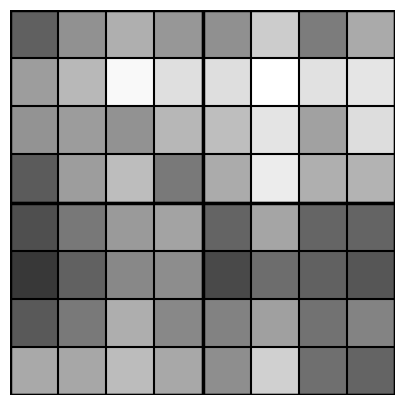

In [96]:
fs(5,5)
indStart = 68
indEnds = 76

z = np.nanmean(allMat,axis = 0)
plt.imshow(z[indStart:indEnds,indStart:indEnds],cmap = 'gist_yarg',vmax=0.53,vmin=-0.46)


plt.vlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 1.5)

plt.hlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 1.5)

plt.vlines(np.arange(0,indEnds - indStart+0.5,1)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 1.5)

plt.hlines(np.arange(0,indEnds - indStart+0.5,1)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 1.5)



plt.vlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 2.5)

plt.hlines(np.arange(0,indEnds - indStart+1,4)-0.5,-0.5, indEnds - indStart-0.5,
            colors='black',linewidth = 2.5)

plt.axis('off')

# same vs diff

In [17]:
comparison = 'stim2delay'#'delay2delay'#'stim2stim'#

In [18]:
meanDf = trl_withScore_formatted.groupby(['participant','category','task',]).mean(numeric_only=True).reset_index()

In [19]:
what2Draw =  ['across, same image', 'across, diff image']
if comparison == 'stim2delay':      
    what2Draw = ['within','across, same image', 'across, diff image']
meanDf_conditioned = trl_withScore_formatted.groupby(['participant','category','task','trlType']).mean(numeric_only=True).reset_index()    
acrossSameDiff = meanDf_conditioned[meanDf_conditioned.category.isin(what2Draw)]

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [21]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [22]:
# Fit the model
model = ols('similarityScore_stim2delay ~ C(task) * C(category)', data=meanDf).fit()

# Perform the ANOVA
anova_results = anova_lm(model, typ=2)
anova_results

,sum_sq,df,F,PR(>F)
C(task),0.022,1.000,10.753,0.001
C(category),0.549,6.000,45.153,0.000
C(task):C(category),0.023,6.000,1.917,0.076
Residual,1.135,560.000,NaN,NaN


In [23]:

# Calculate Partial Eta Squared (η²)
SS_effect = anova_results['sum_sq']['C(task)']  # Between-group effect
SS_error = anova_results['sum_sq']['Residual']  # Error term
eta_squared_group = SS_effect / (SS_effect + SS_error)

SS_within = anova_results['sum_sq']['C(category)']  # Within-group effect
eta_squared_within = SS_within / (SS_within + SS_error)

SS_interact = anova_results['sum_sq']['C(task):C(category)'] 
eta_squared_interact = SS_interact/(SS_interact + SS_error)

# Print the results
print(f"Partial Eta Squared (Between-Group): {eta_squared_group:.4f}")
print(f"Partial Eta Squared (Within-Group): {eta_squared_within:.4f}")
print(f"Partial Eta Squared (interaction): {eta_squared_interact:.4f}")

Partial Eta Squared (Between-Group): 0.0188
Partial Eta Squared (Within-Group): 0.3260
Partial Eta Squared (interaction): 0.0201


In [34]:
print('within trial:', stats.ttest_ind(meanDf[(meanDf.task =='precue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),'cohen d:',
                        round(cohenD(meanDf[(meanDf.task =='precue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'within')][f'similarityScore_{comparison}']),2))

print('same image:',stats.ttest_ind(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),'cohen d:',
                        round(cohenD(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}']),2))

print('across image:',stats.ttest_ind(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),'cohen d:',
                        round(cohenD(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}']),2))

within trial: TtestResult(statistic=1.5283454408129664, pvalue=0.13037125356101822, df=80.0) cohen d: 0.34
same image: TtestResult(statistic=5.547549820567645, pvalue=3.6324556916417875e-07, df=80.0) cohen d: 1.23
across image: TtestResult(statistic=-1.0146291231873545, pvalue=0.3133415038414265, df=80.0) cohen d: -0.22


In [40]:
print('follow up t tests for the three comparison conditions:\n')

print('within to same image \n-----------')
print('precue:',stats.ttest_rel(meanDf[(meanDf.task =='precue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),
        'cohen d:',round(cohenD(meanDf[(meanDf.task =='precue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}']),2) )

print('retrocue:',stats.ttest_rel(meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),
        'cohen d:',round(cohenD(meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'within')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}']),2))

print(' ')
print('same image to diff image \n-----------')
print('precue:',stats.ttest_rel(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),
        'cohen d:', round(cohenD(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}']),2))

print('retrocue:',stats.ttest_rel(meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit'),
        'cohen d:', round(cohenD(meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}']),2))

print(' ')
print('diff image to null \n-----------')

print('precue:',stats.ttest_1samp(meanDf[(meanDf.task =='precue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                                  0,alternative = 'less'))
print('retrocue:',stats.ttest_1samp(meanDf[(meanDf.task =='retrocue') & (meanDf.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                                  0))


follow up t tests for the three comparison conditions:

within to same image 
-----------
precue: TtestResult(statistic=5.490836114583843, pvalue=2.4518195307751756e-06, df=40) cohen d: 1.17
retrocue: TtestResult(statistic=8.95614575900465, pvalue=4.1998589699368274e-11, df=40) cohen d: 1.93
 
same image to diff image 
-----------
precue: TtestResult(statistic=9.815024945214736, pvalue=3.2997514700096387e-12, df=40) cohen d: 2.22
retrocue: TtestResult(statistic=2.9207622107231974, pvalue=0.00571411830191146, df=40) cohen d: 0.59
 
diff image to null 
-----------
precue: TtestResult(statistic=-11.358455303690786, pvalue=2.1645973972630096e-14, df=40)
retrocue: TtestResult(statistic=-0.23159427959983722, pvalue=0.8180338443865709, df=40)


In [31]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'precue'], dv = f'similarityScore_{comparison}',
    within = ['category',],subject = 'participant',
    effsize = 'np2')
aov['p-unc'] = aov['p-unc'].round(5)

same2diffImage = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit')
print(f'same image to diff image {comparison},{same2diffImage}')

if comparison =='stim2delay':
    same2diffImage = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'within')][f'similarityScore_{comparison}'], \
                            acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, same image')][f'similarityScore_{comparison}'],\
                            nan_policy='omit')
    print(f'within trial to same image {comparison},{same2diffImage}')

aov

same image to diff image stim2delay,TtestResult(statistic=11.323456260978924, pvalue=2.283453395296694e-18, df=81)
within trial to same image stim2delay,TtestResult(statistic=6.156174795830509, pvalue=2.710691527058715e-08, df=81)


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,category,2,80,46.146,0.000,0.536,0.542


In [32]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'retrocue'], dv = f'similarityScore_{comparison}',
    within = ['category',],subject = 'participant',
    effsize = 'np2')
aov['p-unc'] = aov['p-unc'].round(5)

same2diffImage = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, same image')][f'similarityScore_{comparison}'], \
                        acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, diff image')][f'similarityScore_{comparison}'],\
                        nan_policy='omit')
print(f'same image to diff image {comparison},{same2diffImage}')

if comparison =='stim2delay':
    same2diffImage = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'within')][f'similarityScore_{comparison}'], \
                            acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, same image')][f'similarityScore_{comparison}'],\
                            nan_policy='omit')
    print(f'within trial to same image {comparison},{same2diffImage}')

aov

same image to diff image stim2delay,TtestResult(statistic=3.323278898840361, pvalue=0.0013372750207245004, df=81)
within trial to same image stim2delay,TtestResult(statistic=7.857960235798306, pvalue=1.4299714257717847e-11, df=81)


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,category,2,80,92.748,0.000,0.699,0.583


In [33]:
trlTypeComp = trl_withScore_formatted.groupby(['participant','category','task','trlType']).mean(numeric_only=True).reset_index()

trlTypeComp = trlTypeComp[trlTypeComp.category.isin(what2Draw)]

pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'retrocue'], dv = f'similarityScore_{comparison}',
    within = ['category',],subject = 'participant',
    effsize = 'np2')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,category,2,80,92.748,0.000,0.699,0.583


In [28]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'precue'], dv = f'similarityScore_{comparison}',
    within = ['category','trlType'],subject = 'participant',
    effsize = 'np2')

aov['p-unc'] = aov['p-unc'].round(5)
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,category,0.429,2,80,0.214,46.146,0.000,0.000,0.536,0.542
1,trlType,0.123,1,40,0.123,12.800,0.001,0.001,0.242,1.000
2,category * trlType,0.019,2,80,0.009,4.112,0.020,0.046,0.093,0.541


In [29]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'retrocue'], dv = f'similarityScore_{comparison}',
    within = ['category','trlType'],subject = 'participant',
    effsize = 'np2')
aov['p-unc'] = aov['p-unc'].round(5)
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,category,0.294,2,80,0.147,92.748,0.000,0.000,0.699,0.583
1,trlType,0.004,1,40,0.004,0.353,0.556,0.556,0.009,1.000
2,category * trlType,0.009,2,80,0.004,1.844,0.165,0.182,0.044,0.517


In [30]:
plt.rcParams['font.family'] = 'arial'

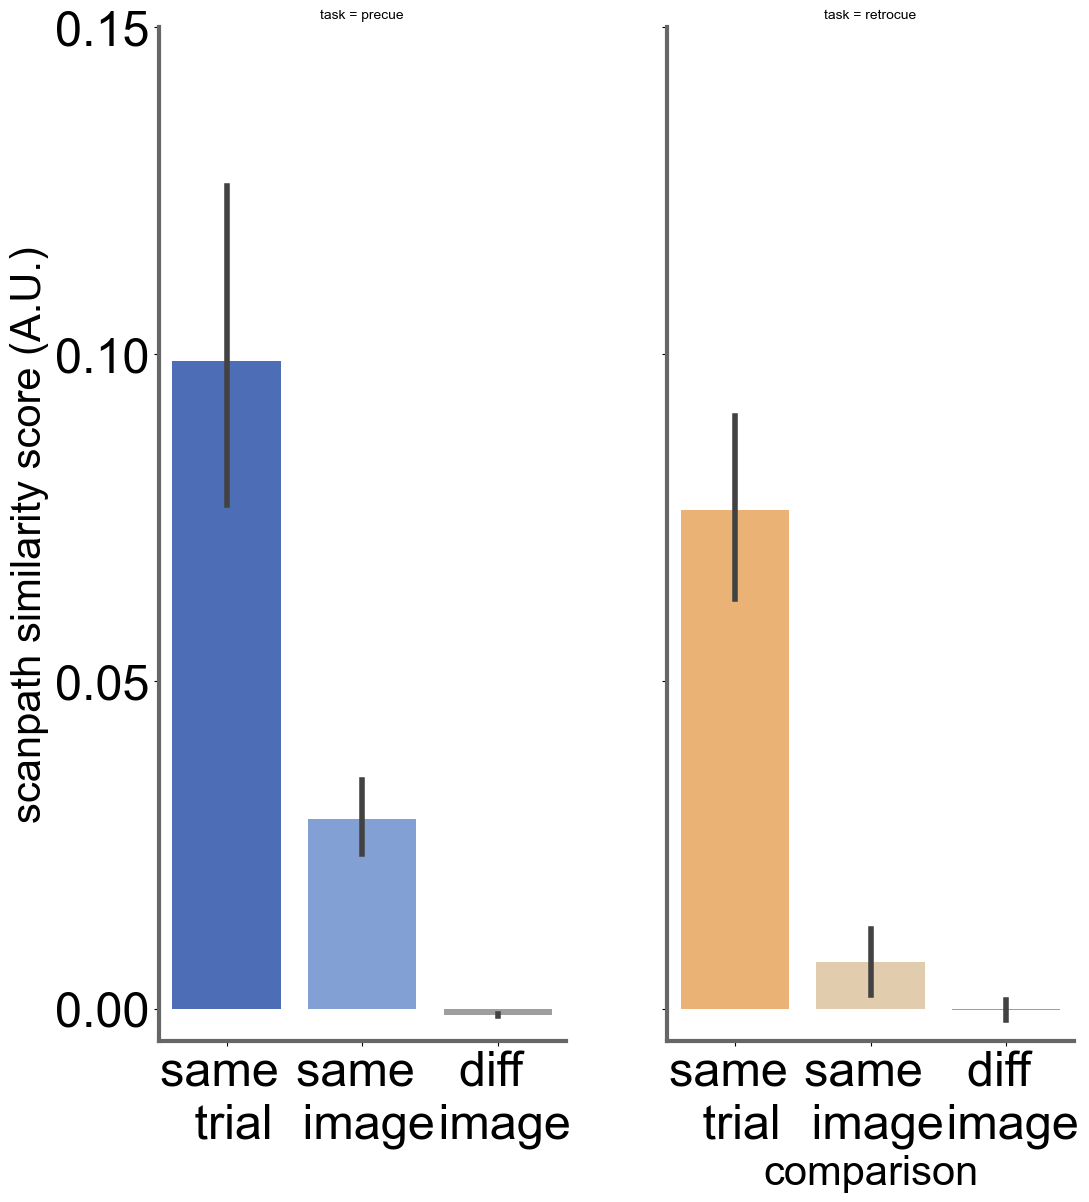

In [31]:
meanDf_noCondition = trl_withScore_formatted.groupby(['participant','category','task',]).mean(numeric_only=True).reset_index()
acrossSameDiff_noCondition = meanDf_noCondition[meanDf_noCondition.category.isin(what2Draw)]


if comparison !='stim2delay':
    melted = pd.melt(acrossSameDiff_noCondition, id_vars=['participant','category','task'], value_vars=['similarityScore_stim2stim','similarityScore_delay2delay'], 
                  var_name='comparison', value_name='similarityScore')
    f = sns.catplot(hue = 'category', x = 'task', y =f'similarityScore',
                hue_order = what2Draw,palette=['#9e9e9eff','#759ce0',],
                aspect=0.5,height=10,kind = 'bar', linewidth = 5,
            data = melted[melted.comparison =='similarityScore_stim2stim'])
    #plt.xticks(ticks=[0, 1], labels=[ 'stim\nto\nstim', 'delay\nto\ndelay'],fontsize = 30)
    
    ax = f.axes[0, 0]
    colors = ['#82a0d3','#e2ccae','#9e9e9eff','#9e9e9eff',]
    for bar, color in zip(ax.patches, colors):
        
        bar.set_facecolor(color)
    f.fig.set_size_inches(10, 12)

    #ax.lines[0].set_color('#79c7b8')
    #ax.lines[1].set_color('#79c7b8')
    #ax.lines[2].set_color('#79c7b8')
    f.fig.set_size_inches(10, 12)

else:
    
    f = sns.catplot(x = 'category', hue = 'category', palette = ['#9e9e9eff','#759ce0','#3b66c8',],y =f'similarityScore_{comparison}',
                order = what2Draw,
                col = 'task',aspect=0.5,height=10,kind = 'bar',errwidth = 4,
            data = acrossSameDiff_noCondition)
    plt.xticks(ticks=[0, 1, 2], labels=['same \n trial', 'same \n image', 'diff \n image'])
    ax = f.axes[0, 1]
    colors = ['#9e9e9eff','#e2ccae','#eab375',]
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)
    f.fig.set_size_inches(10, 12)



plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))
f.set_axis_labels('comparison','scanpath similarity score (A.U.)',fontsize = 30)




for ax in f.axes.flat:
    ax.tick_params(labelsize=35)
    for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_color('#666666')


f.axes[0, 0].set_xlabel('',fontsize = 15)
#f.axes[0, 1].set_xlabel('',fontsize = 15)
plt.subplots_adjust(top=0.9)
#plt.suptitle(f'subj average \n {comparison} comparison',fontsize = 20,y = 1)

plt.ylim(-0.005,0.15)

plt.subplots_adjust(wspace=0.25)



In [ ]:
stats.ttest_rel(acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='precue') & (acrossSameDiff_noCondition.category == 'within')].similarityScore_stim2delay,
                acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='precue') & (acrossSameDiff_noCondition.category == 'across, same image')].similarityScore_stim2delay,        
                        nan_policy='omit')

TtestResult(statistic=5.490836114583843, pvalue=2.4518195307751756e-06, df=40)

In [ ]:
stats.ttest_rel(acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='precue') & (acrossSameDiff_noCondition.category == 'across, same image')].similarityScore_stim2delay,
                acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='precue') & (acrossSameDiff_noCondition.category == 'across, diff image')].similarityScore_stim2delay,        
                        nan_policy='omit')

TtestResult(statistic=9.815024945214736, pvalue=3.2997514700096387e-12, df=40)

In [ ]:
stats.ttest_rel(acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='retrocue') & (acrossSameDiff_noCondition.category == 'within')].similarityScore_stim2delay,
                acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='retrocue') & (acrossSameDiff_noCondition.category == 'across, same image')].similarityScore_stim2delay,        
                        nan_policy='omit')

TtestResult(statistic=8.95614575900465, pvalue=4.1998589699368274e-11, df=40)

In [ ]:
stats.ttest_rel(acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='retrocue') & (acrossSameDiff_noCondition.category == 'across, same image')].similarityScore_stim2delay,
                acrossSameDiff_noCondition[(acrossSameDiff_noCondition.task =='retrocue') & (acrossSameDiff_noCondition.category == 'across, diff image')].similarityScore_stim2delay,        
                        nan_policy='omit')

TtestResult(statistic=2.9207622107231974, pvalue=0.00571411830191146, df=40)

In [ ]:
withTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossSameImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, same image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, same image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossDiffImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, diff image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'across, diff image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

print(f'within: {withTest}\nsame image {acrossSameImgTest} \ndiff image {acrossDiffImgTest}')


within: TtestResult(statistic=4.131279541407043, pvalue=0.0001786880409792572, df=40)
same image TtestResult(statistic=2.091675925901768, pvalue=0.04286174367235476, df=40) 
diff image TtestResult(statistic=2.45843989799134, pvalue=0.0183799484555598, df=40)


In [ ]:
withTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossSameImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, same image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, same image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossDiffImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, diff image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'across, diff image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

print(f'within: {withTest}\nsame image {acrossSameImgTest} \ndiff image {acrossDiffImgTest}')

within: TtestResult(statistic=1.1451490409621379, pvalue=0.258953113323784, df=40)
same image TtestResult(statistic=-0.1603604903262404, pvalue=0.8734042249271989, df=40) 
diff image TtestResult(statistic=0.08841778176440077, pvalue=0.9299858289243964, df=40)


# conditioned (only for the same base-target trl type)

In [36]:
acrossSameDiff = meanDf_conditioned[meanDf_conditioned.category.isin([
                    'within',
                    'across, same image, visTarget',
                    'across, same image, verTarget',
                    'across, diff image, visTarget',
                    'across, diff image, verTarget',
                    ])].reset_index(drop = True)

In [37]:
# add in tags

tarType = []

for targetType,baseType in zip(acrossSameDiff.category,acrossSameDiff.trlType):
    if 'vis' in targetType:
        tarType.append('visual')
    elif 'ver' in targetType:
        tarType.append('verbal')
    else:
        tarType.append(baseType)

acrossSameDiff['targetType'] = tarType


cateType = []

for i in acrossSameDiff.category:
    if 'same' in i:
        cateType.append('same image')
    elif 'diff' in i:
        cateType.append('diff image')
    else:
        cateType.append('within')
acrossSameDiff['category'] = cateType

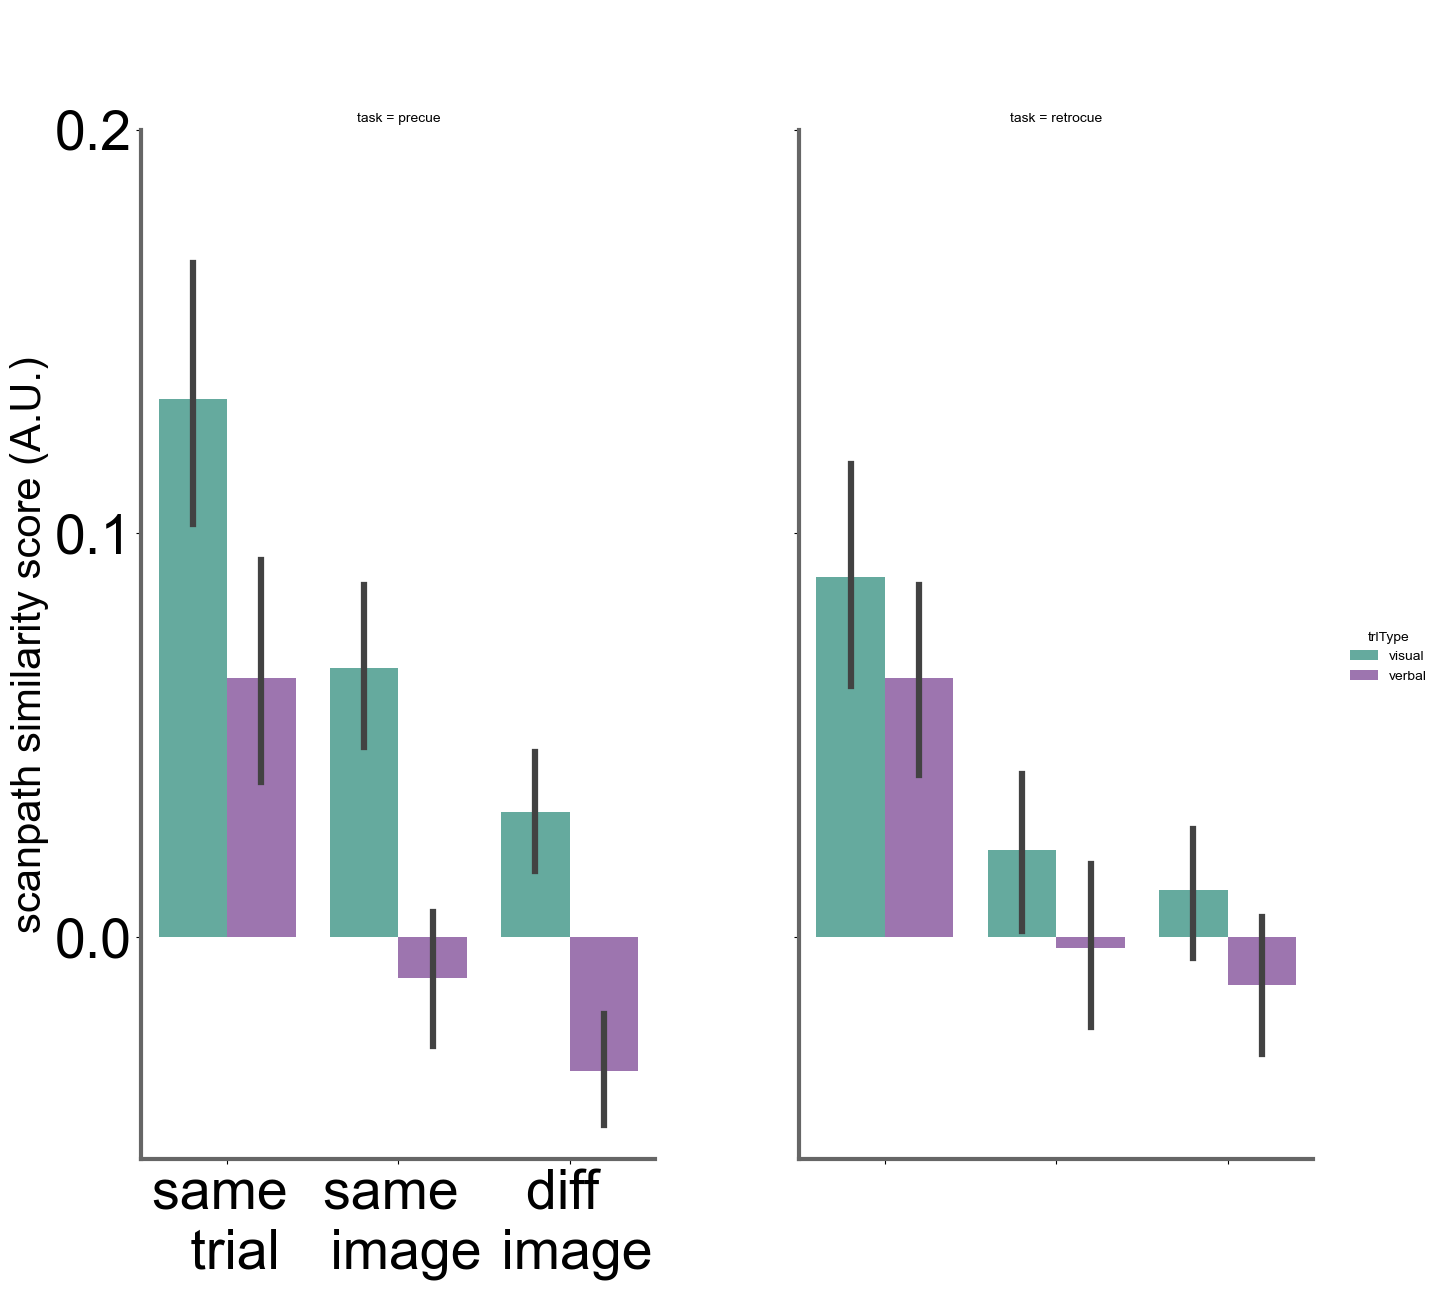

In [38]:
f = sns.catplot(x = 'category', y =f'similarityScore_{comparison}',hue = 'trlType',
                order = ['within','same image','diff image'],
                col = 'task',aspect=0.4,height=13,linewidth = 5,errwidth = 4.5,
            palette = ['#59b6a6','#a06bb9'],hue_order=['visual','verbal'],kind = 'bar',
            data = acrossSameDiff[acrossSameDiff.trlType == acrossSameDiff.targetType])

for ax in f.axes.flat:
    ax.tick_params(labelsize=30)

f.fig.set_size_inches(14, 12)
plt.xticks(ticks=[0, 1, 2],color = 'white', labels=['same \n trial', 'same \n image', 'diff \n image'])

f.set_axis_labels('comparison','scanpath similarity score (A.U.)',fontsize = 30)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

f.axes[0, 0].set_xlabel('',fontsize = 15)
f.axes[0, 1].set_xlabel('',fontsize = 15)

if comparison == 'stim2stim':
    f.axes.flat[0].text(x = -0.01,y = 0.25, s = 'ns',fontdict={'fontsize':20})
elif comparison =='delay2delay':
    f.axes.flat[0].text(x = -0.01,y = 0.055, s = 'sig interaction',fontdict={'fontsize':20})
    f.axes.flat[1].text(x = -0.01,y = 0.055, s = 'almost sig interaction',fontdict={'fontsize':20})

plt.xlabel('condition',fontsize = 15,color = 'white')
plt.subplots_adjust(top=0.9)
plt.suptitle(f'subj average \n {comparison} comparison',color = 'white',fontsize = 20,y = 1)

#plt.ylim(2.4,2.55)
plt.ylim(-0.055,0.2)
plt.subplots_adjust(wspace=0.28)

for ax in f.axes.flat:
    ax.tick_params(labelsize=40)
    for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_color('#666666')

In [39]:
withTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossSameImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'same image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'same image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossDiffImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'diff image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='precue') & (acrossSameDiff.category == 'diff image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

print(f'within: {withTest}\nsame image {acrossSameImgTest} \ndiff image {acrossDiffImgTest}')


within: TtestResult(statistic=4.131279541407043, pvalue=0.0001786880409792572, df=40)
same image TtestResult(statistic=3.563896071476923, pvalue=0.0006159910072039709, df=81) 
diff image TtestResult(statistic=3.4972259892535704, pvalue=0.0007661505984910771, df=81)


In [40]:
withTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'within')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossSameImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'same image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'same image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

acrossDiffImgTest = stats.ttest_rel(acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'diff image')&(acrossSameDiff.trlType == 'visual')].similarityScore_stim2delay,
                acrossSameDiff[(acrossSameDiff.task =='retrocue') & (acrossSameDiff.category == 'diff image')&(acrossSameDiff.trlType == 'verbal')].similarityScore_stim2delay,        
                        nan_policy='omit')

print(f'within: {withTest}\nsame image {acrossSameImgTest} \ndiff image {acrossDiffImgTest}')


within: TtestResult(statistic=1.1451490409621379, pvalue=0.258953113323784, df=40)
same image TtestResult(statistic=0.19033651829524886, pvalue=0.849521658881958, df=81) 
diff image TtestResult(statistic=0.12810254253009615, pvalue=0.8983853430752224, df=81)


In [41]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'precue'], dv = f'similarityScore_{comparison}',
    within = ['category','trlType'],subject = 'participant',
    effsize = 'np2')

aov['p-unc'] = aov['p-unc'].round(5)
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,category,0.430,2,80,0.215,45.448,0.000,0.000,0.532,0.549
1,trlType,0.132,1,40,0.132,13.715,0.001,0.001,0.255,1.000
2,category * trlType,0.016,2,80,0.008,4.025,0.022,0.048,0.091,0.547


In [42]:
aov = pg.rm_anova(data = acrossSameDiff[acrossSameDiff.task == 'retrocue'], dv = f'similarityScore_{comparison}',
    within = ['category','trlType'],subject = 'participant',
    effsize = 'np2')
aov['p-unc'] = aov['p-unc'].round(5)
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,category,0.296,2,80,0.148,91.096,0.000,0.000,0.695,0.582
1,trlType,0.005,1,40,0.005,0.455,0.504,0.504,0.011,1.000
2,category * trlType,0.007,2,80,0.004,1.764,0.178,0.192,0.042,0.522


In [43]:
visverDiff = acrossSameDiff[acrossSameDiff.category != 'within']
visverDiff['baseTar'] = visverDiff.trlType + '-' + visverDiff.targetType

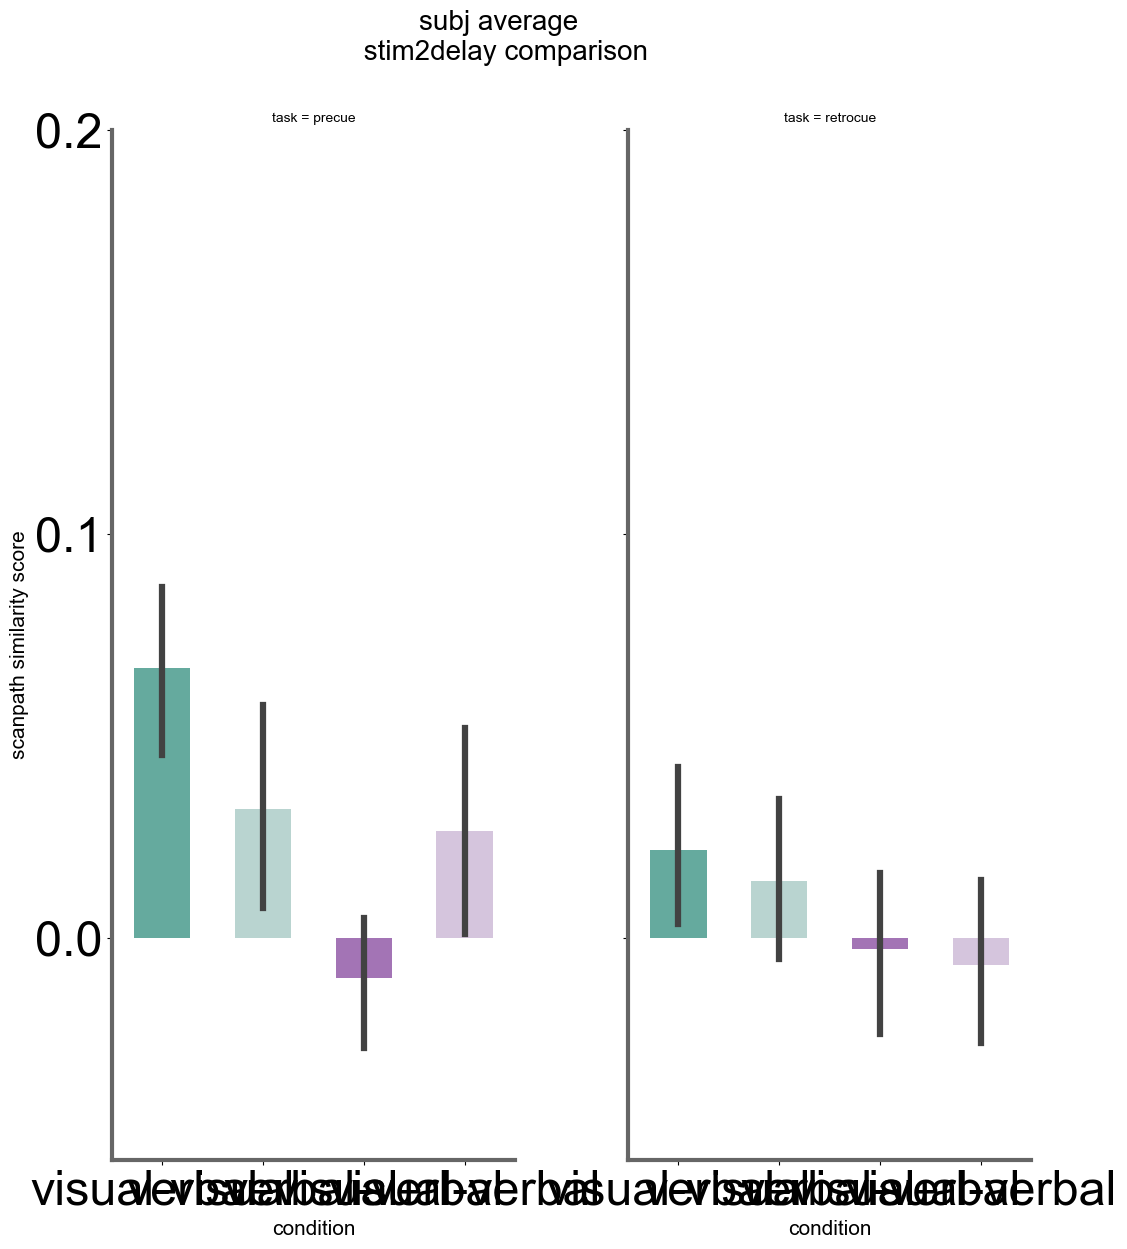

In [64]:
colors = ['#59b6a6','#b4d9d3','#a869c0','#d7c1e1'] #['#82c495','#82c495','#a869c0','#a869c0']

f = sns.catplot(hue = 'baseTar', y =f'similarityScore_{comparison}',x = 'baseTar',
                hue_order = ['visual-visual','verbal-visual','verbal-verbal','visual-verbal',],
                col = 'task',aspect=0.15,height=13,linewidth = 5,errwidth = 4.5,
            palette = colors, order = ['visual-visual','verbal-visual','verbal-verbal','visual-verbal',],kind = 'bar',
            data = visverDiff[visverDiff.category == 'same image'])
f.set_axis_labels('condition','scanpath similarity score',fontsize = 15)

f.fig.set_size_inches(13, 12)
for ax in f.axes.flat:
    ax.tick_params(labelsize=30)
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = current_width * 0.7  # Adjust this factor to control spacing
        patch.set_width(new_width)

        # Center the bar if desired (adjusting x-position)
        x = patch.get_x()
        patch.set_x(x + (current_width - new_width) / 2)


ax = f.axes[0, 1]

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))


if comparison =='delay2delay':
    f.axes.flat[1].text(0,0.07,'sig interaction',fontdict={'fontsize':20})

plt.xlabel('condition',fontsize = 15)
plt.subplots_adjust(top=0.9)
plt.suptitle(f'subj average \n {comparison} comparison',fontsize = 20,y = 1)
plt.ylim(-0.055,0.2)
plt.subplots_adjust(wspace=0.28)

for ax in f.axes.flat:
    ax.tick_params(labelsize=35)
    for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_color('#666666')
